In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import itertools
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from collections import OrderedDict
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

## DATA

### Climate: UEA CRU TS4.07 (1901-2022)

In [2]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.pre.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.tmx.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

### Conflict events: ACLED

In [3]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

### Administrative boundaries of Somalia

In [4]:
path = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm2_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

### Displacements : UNHCR

In [5]:
df_disp = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")

### Population density Data

In [7]:
asc = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/gpw_v4_admin_unit_center_points_population_estimates_rev11_som.csv"
population_density = pd.read_csv(asc)

# Data manipulation

## Climate data manipulation

In [6]:
#Limit the lat-lon and time

def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [7]:
start_date = '1901-01-01'
end_date = '2022-12-31'

region = monthly_forecast[["pre",'tmx']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [28]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()
#add a column with the name of the region in states_gdf['ADM2_EN'] that matches the inde


In [24]:
states_gdf

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,2.403404,0.254702,Borama,SO1101,NaN,NaN,NaN,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((43.33758 9.91064, 43.33108 9.84303, ..."
1,2.871732,0.282351,Baki,SO1102,NaN,NaN,NaN,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.18627 10.38367, 44.15094 10.32089..."
2,2.334286,0.275753,Lughaye,SO1103,NaN,NaN,NaN,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((43.92545 10.54573, 43.75972 10.48709..."
3,3.849710,0.499418,Zeylac,SO1104,NaN,NaN,NaN,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
4,4.584432,1.128979,Hargeysa,SO1201,NaN,NaN,NaN,Woqooyi Galbeed,SO12,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.69096 8.99646, 44.69095 8.77196, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,3.868998,0.654289,Saakow,SO2703,NaN,NaN,NaN,Middle Juba,SO27,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((42.86275 1.55804, 42.95258 1.48303, ..."
70,5.556018,0.748679,Kismaayo,SO2801,NaN,NaN,NaN,Lower Juba,SO28,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((42.03202 -1.01962, 42.02429 -1..."
71,5.871473,2.173960,Afmadow,SO2802,NaN,NaN,NaN,Lower Juba,SO28,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((41.03111 -0.19178, 40.99569 -0.19727..."
72,4.658647,0.793133,Badhaadhe,SO2803,NaN,NaN,NaN,Lower Juba,SO28,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((41.92670 -1.16192, 41.92265 -1..."


In [29]:
temp_pre

,time,region,pre,tmx,ADM2_EN
0,1901-01-16,0,6.400000,27.200001,Borama
1,1901-01-16,2,5.500000,30.200001,Borama
2,1901-01-16,3,8.400001,29.299999,Borama
3,1901-01-16,4,2.800000,27.650002,Borama
4,1901-01-16,5,2.075000,29.174999,Borama
...,...,...,...,...,...
96619,2022-12-16,69,58.500000,34.700001,Borama
96620,2022-12-16,70,16.433334,33.800003,Borama
96621,2022-12-16,71,29.966665,34.688892,Borama
96622,2022-12-16,72,38.825001,33.850002,Borama


In [9]:
temp_pre

,time,region,pre,tmx
0,1901-01-16,0,6.400000,27.200001
1,1901-01-16,2,5.500000,30.200001
2,1901-01-16,3,8.400001,29.299999
3,1901-01-16,4,2.800000,27.650002
4,1901-01-16,5,2.075000,29.174999
...,...,...,...,...
96619,2022-12-16,69,58.500000,34.700001
96620,2022-12-16,70,16.433334,33.800003
96621,2022-12-16,71,29.966665,34.688892
96622,2022-12-16,72,38.825001,33.850002


In [12]:
# Add Banadir region with tmx and pre as mean of the neighbouring regions
district1 = 'Lower_Shabelle'  
district2 = 'Middle_Shabelle'  

# Calculate the mean tmx and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['tmx'].mean()
mean_p = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['pre'].mean()
new_data = pd.DataFrame({ 'admin1': 'Banadir', 'tmx': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
temp_pre_m = pd.concat([temp_pre, new_data])
temp_pre = temp_pre_m.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [13]:
# Only keep month and year in time column 
temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
temp_pre = temp_pre[['month_year','admin1','tmx','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

## Conflict data manipulation

In [13]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

conflict = df.groupby([pd.Grouper(freq='M'),"admin2"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin2','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin2'])['conflicts'].sum().to_frame()

In [21]:

#conf.reset_index(level=[0, 1], inplace=True)
len(conf['admin2'].unique())

74

In [15]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

# Merge the two DataFrames temp_pre and conflicts
df_2016 = pd.merge(temp_pre, conflicts, on=['time','admin1'], how='outer')

## Displacements data manipulation

In [16]:
df_disp = df_disp[(df_disp['Reason']=='Drought related')]
df_disp['Current (Arrival) Region'] = df_disp['Current (Arrival) Region'].str.replace(' ', '_')
df_disp['Previous (Departure) Region'] = df_disp['Previous (Departure) Region'].str.replace(' ', '_')

In [17]:
v= df_disp["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df_disp.insert(loc=3, column='date_timestamp', value=q)
df_disp = df_disp.sort_values("date_timestamp")

df_disp['Month End'] = pd.to_datetime(df_disp['Month End'], dayfirst=True)

In [18]:
aggregated_data = df_disp.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()

# Get the unique values of 'Month End' and 'Previous (Departure) Region' 
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])

# Reindex the aggregated_data DataFrame with 'all_combinations'
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [19]:
disp_matxs = disp_data.pivot_table(index=['time','Current (Arrival) Region'], columns='Previous (Departure) Region', values='Number of Individuals', aggfunc='sum').reset_index()
disp_matxs = disp_matxs.rename(columns={'Current (Arrival) Region': 'admin1'})

#remove the day from the date
disp_matxs['time'] = disp_matxs['time'].map(lambda x: x.strftime('%Y-%m'))
#disp_matxs = disp_matxs.drop(columns=['time'])
#temp_pre_c['yr_mth'] = pd.to_datetime(temp_pre_c['time'], format='%Y-%m', dayfirst=True).map(lambda x: x.strftime('%Y-%m'))

#df_2016 = df_2016.rename(columns={'time': 'yr_mth'})
df_merged_d = pd.merge(df_2016, disp_matxs, on=['time', 'admin1'], how='outer')

In [20]:
#add a column with the sum of the displacements
df_merged_d['sum_disp'] = df_merged_d.iloc[:, -18:].sum(axis=1)

In [21]:
#df_merged.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv", index=False)

## Compute TA, PA, DL

In [22]:
# Split the dataframe into regions

reg=[]
for admin in df_merged_d['admin1'].unique():
    a = df_merged_d[df_merged_d['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [23]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(18)

for i in range(18):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmx'].mean() , reg[i].groupby('month')['tmx'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmx']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(3) + reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/4

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(3) + reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/4
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    # Add lagged variables
    reg[i]['TA_lag1'], reg[i]['TA_lag2'], reg[i]['TA_lag3'], reg[i]['TA_lag4'], reg[i]['TA_lag5'], reg[i]['TA_lag6'] = reg[i]['TA'].shift(1), reg[i]['TA'].shift(2), reg[i]['TA'].shift(3), reg[i]['TA'].shift(4), reg[i]['TA'].shift(5), reg[i]['TA'].shift(6)
    reg[i]['PA_lag1'], reg[i]['PA_lag2'], reg[i]['PA_lag3'], reg[i]['PA_lag4'], reg[i]['PA_lag5'], reg[i]['PA_lag6'] = reg[i]['PA'].shift(1), reg[i]['PA'].shift(2), reg[i]['PA'].shift(3), reg[i]['PA'].shift(4), reg[i]['PA'].shift(5), reg[i]['PA'].shift(6)
    reg[i]['DL_lag1'], reg[i]['DL_lag2'], reg[i]['DL_lag3'], reg[i]['DL_lag4'], reg[i]['DL_lag5'], reg[i]['DL_lag6'] = reg[i]['DL'].shift(1), reg[i]['DL'].shift(2), reg[i]['DL'].shift(3), reg[i]['DL'].shift(4), reg[i]['DL'].shift(5), reg[i]['DL'].shift(6)
    reg[i]['conflicts_lag1'], reg[i]['conflicts_lag2'], reg[i]['conflicts_lag3'], reg[i]['conflicts_lag4'], reg[i]['conflicts_lag5'], reg[i]['conflicts_lag6'] = reg[i]['conflicts'].shift(1), reg[i]['conflicts'].shift(2), reg[i]['conflicts'].shift(3), reg[i]['conflicts'].shift(4), reg[i]['conflicts'].shift(5), reg[i]['conflicts'].shift(6)
    reg[i]['sum_disp_lag1'], reg[i]['sum_disp_lag2'], reg[i]['sum_disp_lag3'], reg[i]['sum_disp_lag4'], reg[i]['sum_disp_lag5'], reg[i]['sum_disp_lag6'] = reg[i]['sum_disp'].shift(1), reg[i]['sum_disp'].shift(2), reg[i]['sum_disp'].shift(3), reg[i]['sum_disp'].shift(4), reg[i]['sum_disp'].shift(5), reg[i]['sum_disp'].shift(6)
    reg[i] = reg[i].reset_index()

In [24]:
# print reg[0] from 2016
reg[0][reg[0]['time']>= '2016-01']

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,...,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6
1380,1380,2016-01,Awdal,30.050001,3.775000,4.0,0.0,7.0,26.0,0.0,...,9.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1381,1381,2016-02,Awdal,31.325003,18.100000,9.0,0.0,0.0,41.0,0.0,...,6.0,9.0,6.0,1.0,89.0,0.0,0.0,0.0,0.0,0.0
1382,1382,2016-03,Awdal,34.950001,9.650000,2.0,39.0,0.0,16.0,0.0,...,4.0,6.0,9.0,6.0,83.0,89.0,0.0,0.0,0.0,0.0
1383,1383,2016-04,Awdal,33.049999,88.150002,3.0,80.0,0.0,30.0,0.0,...,4.0,4.0,6.0,9.0,66.0,83.0,89.0,0.0,0.0,0.0
1384,1384,2016-05,Awdal,34.174999,36.250000,3.0,11.0,0.0,36.0,8.0,...,9.0,4.0,4.0,6.0,158.0,66.0,83.0,89.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1467,2023-04,Awdal,NaN,NaN,0.0,107.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,702.0,815.0,114.0,625.0,893.0,660.0
1468,1468,2023-05,Awdal,NaN,NaN,3.0,263.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,107.0,702.0,815.0,114.0,625.0,893.0
1469,1469,2023-06,Awdal,NaN,NaN,0.0,278.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,263.0,107.0,702.0,815.0,114.0,625.0
1470,1470,2023-07,Awdal,NaN,NaN,0.0,798.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,278.0,263.0,107.0,702.0,815.0,114.0


In [25]:
temp_pre_c = pd.concat([reg[i] for i in range(18)], axis=0)
#temp_pre_c = temp_pre_c.dropna()
# drop all entries before 2016-01 and after 2022-12
temp_pre_c = temp_pre_c[(temp_pre_c['time'] >= '2016-01') & (temp_pre_c['time'] <= '2022-12')]
# Select a subset of the dataframes from 1997-01 to 2022-12
temp_pre_c = temp_pre_c.fillna(0)
temp_pre_c = temp_pre_c.drop(['avg_temp', 'avg_pre', 'std_temp', 'std_pre', 'diff_t', 'diff_p'], axis=1)
temp_pre_c = temp_pre_c.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)

In [27]:
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
temp_pre_c['month_name'] = temp_pre_c['month'].map(month_dict)

In [28]:
#temp_pre_c.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_c.csv", index = False, header=True)

## Population density 

In [29]:
population_density = population_density.groupby('NAME2')[['UN_2000_DS','UN_2005_DS','UN_2010_DS','UN_2015_DS','UN_2020_DS']].sum()
population_density.rename(index={'Juba Dhexe (Middle)':'Middle_Juba','Juba Hoose (Lower)':'Lower_Juba','Shabelle Dhexe (Middle)':'Middle_Shabelle','Shabelle Hoose (Lower)':'Lower_Shabelle','Woqooyi Galbeed':'Woqooyi_Galbeed'},inplace=True)	

population_density['UN_2001_DS']=population_density['UN_2000_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2002_DS']=population_density['UN_2001_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2003_DS']=population_density['UN_2002_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2004_DS']=population_density['UN_2003_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2006_DS']=population_density['UN_2005_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2007_DS']=population_density['UN_2006_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2008_DS']=population_density['UN_2007_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2009_DS']=population_density['UN_2008_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2011_DS']=population_density['UN_2010_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2012_DS']=population_density['UN_2011_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2013_DS']=population_density['UN_2012_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2014_DS']=population_density['UN_2013_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2016_DS']=population_density['UN_2015_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2017_DS']=population_density['UN_2016_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2018_DS']=population_density['UN_2017_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2019_DS']=population_density['UN_2018_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2021_DS']=population_density['UN_2020_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2022_DS']=population_density['UN_2021_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5

In [30]:
population_density=population_density[['UN_2000_DS','UN_2001_DS','UN_2002_DS','UN_2003_DS','UN_2004_DS','UN_2005_DS','UN_2006_DS','UN_2007_DS','UN_2008_DS','UN_2009_DS','UN_2010_DS','UN_2011_DS','UN_2012_DS','UN_2013_DS','UN_2014_DS','UN_2015_DS','UN_2016_DS','UN_2017_DS','UN_2018_DS','UN_2019_DS','UN_2020_DS','UN_2021_DS','UN_2022_DS']]
population_density.reset_index(inplace=True)
population_density.rename(columns={'NAME2':'admin1','UN_2000_DS':'2000','UN_2001_DS':'2001','UN_2002_DS':'2002','UN_2003_DS':'2003','UN_2004_DS':'2004','UN_2005_DS':'2005','UN_2006_DS':'2006','UN_2007_DS':'2007','UN_2008_DS':'2008','UN_2009_DS':'2009','UN_2010_DS':'2010','UN_2011_DS':'2011','UN_2012_DS':'2012','UN_2013_DS':'2013','UN_2014_DS':'2014','UN_2015_DS':'2015','UN_2016_DS':'2016','UN_2017_DS':'2017','UN_2018_DS':'2018','UN_2019_DS':'2019','UN_2020_DS':'2020','UN_2021_DS':'2021','UN_2022_DS':'2022'},inplace=True)

#pivot the table to have the years as rows
population_density=population_density.melt(id_vars=['admin1'],value_vars=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022'],var_name='year',value_name='population_density')
population_density['year']=population_density['year']

df_merged=pd.merge(temp_pre_c,population_density,how='left',on=['year','admin1'])

In [31]:
df_merged = df_merged[df_merged['conflicts']!=0]
df_merged['conflicts_log'] = np.log(df_merged['conflicts'])
df_merged['sum_disp_log'] = np.log(df_merged['sum_disp']+1) 

## Standardization

In [32]:
col1=[ 'tmx', 'pre',
       'TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5', 'TA_lag6',  
       'PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5', 'PA_lag6', 
       'DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5', 'DL_lag6', 
       'conflicts', 'conflicts_lag1', 'conflicts_lag2', 'conflicts_lag3',
       'conflicts_lag4', 'conflicts_lag5', 'conflicts_lag6',
       'sum_disp', 'sum_disp_lag1', 'sum_disp_lag2', 'sum_disp_lag3',
       'sum_disp_lag4', 'sum_disp_lag5', 'sum_disp_lag6', 
       'population_density', 'conflicts_log', 'sum_disp_log']

df_merged_std = df_merged.copy()
scaler = StandardScaler().fit(df_merged_std[col1])
df_merged_std[col1] = scaler.transform(df_merged_std[col1])
df_merged_std.head()


,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,...,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6,month_name,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,-1.416274,-0.655943,-0.630800,0.0,7.0,26.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.237654,-0.595111,-0.318569
1,1380,2016-01,Bakool,0.964932,-0.713333,-0.516282,0.0,0.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.261290,-0.249183,-1.980973
2,1380,2016-01,Banadir,0.283040,-0.593444,1.201489,0.0,0.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,3.572026,1.279481,-1.980973
3,1380,2016-01,Bari,-1.964222,-0.648755,-0.516282,0.0,0.0,23.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.286821,-0.249183,-0.700596
4,1380,2016-01,Bay,0.914679,-0.685610,0.056308,0.0,14.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.264016,0.587625,-0.228011


In [41]:
df_merged_std

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,...,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6,month_name,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,-1.416274,-0.655943,-0.630800,0.0,7.0,26.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.237654,-0.595111,-0.318569
1,1380,2016-01,Bakool,0.964932,-0.713333,-0.516282,0.0,0.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.261290,-0.249183,-1.980973
2,1380,2016-01,Banadir,0.283040,-0.593444,1.201489,0.0,0.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,3.572026,1.279481,-1.980973
3,1380,2016-01,Bari,-1.964222,-0.648755,-0.516282,0.0,0.0,23.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.286821,-0.249183,-0.700596
4,1380,2016-01,Bay,0.914679,-0.685610,0.056308,0.0,14.0,0.0,0.0,...,-0.281277,-0.276586,-0.267289,-0.262538,-0.257673,-0.251247,NaN,-0.264016,0.587625,-0.228011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1463,2022-12,Middle_Shabelle,-0.166139,-0.184478,2.060375,0.0,0.0,0.0,0.0,...,-0.185079,-0.201485,-0.174768,-0.173136,0.134456,-0.126327,NaN,-0.202486,1.576644,0.459780
1506,1463,2022-12,Mudug,-0.466022,-0.486679,-0.459023,0.0,0.0,0.0,0.0,...,0.146300,0.066091,-0.132077,-0.032526,0.006726,0.410914,NaN,-0.271542,-0.117667,0.422516
1507,1463,2022-12,Nugaal,-1.459566,-0.655810,-0.802578,0.0,0.0,0.0,0.0,...,0.050661,-0.122860,0.039829,-0.200887,-0.193375,-0.178304,NaN,-0.310650,-1.777847,0.689742
1509,1463,2022-12,Sool,-2.034124,-0.744406,-0.401764,0.0,0.0,0.0,0.0,...,-0.265198,-0.206980,-0.128793,0.247980,-0.172327,0.659297,NaN,-0.309233,-0.003743,0.431248


In [33]:
#df_merged_std.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_std_log_c.csv", index=False)

In [34]:
df_merged_std['conflicts_log'].mean()
df_merged_std['conflicts'].mean()

-5.130272460361734e-18

## Normalization

In [35]:
col1=[ 'tmx', 'pre', 'conflicts', 
       'TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5', 'TA_lag6',  
       'PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5', 'PA_lag6', 
       'DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5', 'DL_lag6', 
        'conflicts_lag1', 'conflicts_lag2', 'conflicts_lag3',
       'conflicts_lag4', 'conflicts_lag5', 'conflicts_lag6',
       'sum_disp', 'sum_disp_lag1', 'sum_disp_lag2', 'sum_disp_lag3',
       'sum_disp_lag4', 'sum_disp_lag5', 'sum_disp_lag6', 
       'population_density', 'conflicts_log', 'sum_disp_log']

df_merged_norm = df_merged.copy()
min_max_scaler = MinMaxScaler().fit(df_merged_norm[col1])
df_merged_norm[col1] = min_max_scaler.transform(df_merged_norm[col1])

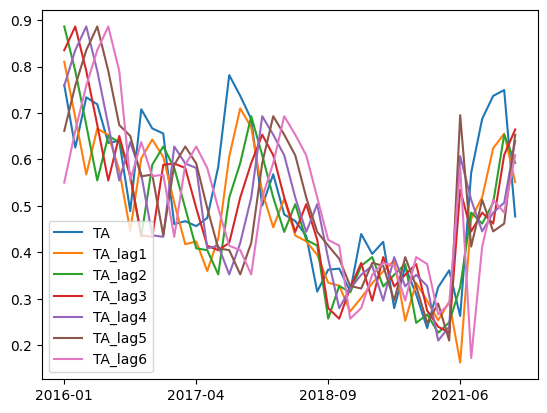

In [36]:
df_merged_norm[df_merged_norm['admin1']=='Awdal']
#plot TA, TA_lag1, .. against time in the same plot
pl = df_merged_norm[df_merged_norm['admin1']=='Awdal']
fig, ax = plt.subplots()
ax.plot(pl['time'], pl['TA'], label='TA')
ax.plot(pl['time'], pl['TA_lag1'], label='TA_lag1')
ax.plot(pl['time'], pl['TA_lag2'], label='TA_lag2')
ax.plot(pl['time'], pl['TA_lag3'], label='TA_lag3')
ax.plot(pl['time'], pl['TA_lag4'], label='TA_lag4')
ax.plot(pl['time'], pl['TA_lag5'], label='TA_lag5')
ax.plot(pl['time'], pl['TA_lag6'], label='TA_lag6')
#change x axis to show only the years
ax.set_xticks(pl['time'][::12])
ax.legend()
plt.show()


In [37]:
#df_merged_norm.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_log_d_lag.csv", index=False)

In [38]:
#read csv
df_mer_1 = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_log_d.csv")
df_mer_1[df_mer_1['admin1']=='Awdal'].head()

,index,time,admin1,tmx,pre,conflicts,year,month,TA,PA,...,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,0.291470,0.010244,0.041667,2016,1,0.760128,0.237045,...,0,6,0,0,0,0,0.000757,0.016448,0.351812,0.385427
18,1381,2016-02,Awdal,0.385817,0.052913,0.093750,2016,2,0.625460,0.360233,...,12,18,0,0,0,0,0.000706,0.016448,0.503329,0.379518
36,1382,2016-03,Awdal,0.654060,0.027743,0.020833,2016,3,0.733622,0.364569,...,4,0,0,0,0,0,0.000561,0.016448,0.240149,0.360149
54,1383,2016-04,Awdal,0.513463,0.261563,0.031250,2016,4,0.718720,0.562699,...,0,5,0,0,0,0,0.001344,0.016448,0.303034,0.434172
72,1384,2016-05,Awdal,0.596711,0.106974,0.031250,2016,5,0.635453,0.664635,...,0,16,0,0,0,0,0.000893,0.016448,0.303034,0.399443


## Displacements data manipulation

In [39]:
df_disp = df_disp[(df_disp['Reason']=='Drought related')]
df_disp['Current (Arrival) Region'] = df_disp['Current (Arrival) Region'].str.replace(' ', '_')
df_disp['Previous (Departure) Region'] = df_disp['Previous (Departure) Region'].str.replace(' ', '_')

In [40]:
v= df_disp["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df_disp.insert(loc=3, column='date_timestamp', value=q)
df_disp = df_disp.sort_values("date_timestamp")

df_disp['Month End'] = pd.to_datetime(df_disp['Month End'], dayfirst=True)

TypeError: strptime() argument 1 must be str, not numpy.datetime64

In [ ]:
aggregated_data = df_disp.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()

# Get the unique values of 'Month End' and 'Previous (Departure) Region' 
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])

# Reindex the aggregated_data DataFrame with 'all_combinations'
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [ ]:
df_2016
#rename time column to match the one in disp_data
df_2016 = df_2016.rename(columns={'time': 'yr_mth'})

In [ ]:
disp_matxs = disp_data.pivot_table(index=['time','Current (Arrival) Region'], columns='Previous (Departure) Region', values='Number of Individuals', aggfunc='sum').reset_index()
disp_matxs = disp_matxs.rename(columns={'Current (Arrival) Region': 'admin1'})

#remove the day from the date
disp_matxs['yr_mth'] = disp_matxs['time'].map(lambda x: x.strftime('%Y-%m'))
disp_matxs = disp_matxs.drop(columns=['time'])
temp_pre_c['yr_mth'] = pd.to_datetime(temp_pre_c['time'], format='%Y-%m', dayfirst=True).map(lambda x: x.strftime('%Y-%m'))

df_merged = pd.merge(df_2016, disp_matxs, on=['yr_mth', 'admin1'], how='inner')

In [ ]:
#add a column with the sum of the displacements
df_merged['sum_disp'] = df_merged.iloc[:, -18:].sum(axis=1)

In [ ]:
#df_merged.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv", index=False)